# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
## YOUR CODE HERE ##
from torchvision import datasets
from  torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

train_transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                ])
test_transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                ])
#transforms.GaussianBlur(kernel_size, sigma=(0.1, 2.0))

# Create training set and define training dataloader
## YOUR CODE HERE ##

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True, download=True, transform=train_transform)


valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = DataLoader(train_data,batch_size=32,sampler=train_sampler, num_workers=0)
valid_loader = DataLoader(train_data,batch_size=32,sampler=valid_sampler, num_workers=0)



# Create test set and define test dataloader
## YOUR CODE HERE ##
test_data = datasets.CIFAR10('data', train=False,download=True, transform=test_transform)
test_loader = DataLoader(test_data,batch_size=20,num_workers=0)
# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [20]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
        image = images[i].numpy()
        plt.imshow(image.T.clip(0,1))
        plt.show()

training image size(D,H,W):  torch.Size([3, 32, 32])
frog


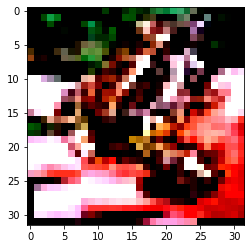

plane


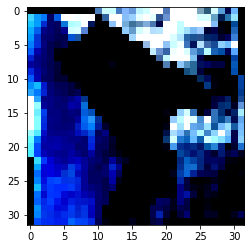

horse


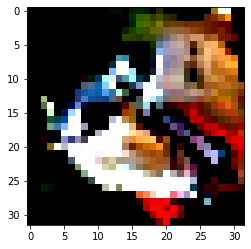

dog


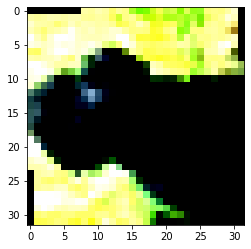

horse


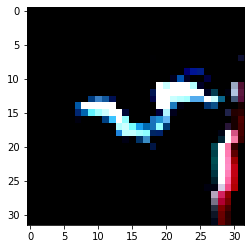

In [21]:
# Explore data
## YOUR CODE HERE ##
dataiter = iter(train_loader)
batch = next(dataiter)
images = batch[0][0]
print("training image size(D,H,W): ",images.shape)

show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [5]:
## YOUR CODE HERE ##
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.c1 = nn.Conv2d(3,32,3,padding=1) # out_______16x16
        self.c2 = nn.Conv2d(32,64,3,padding=1) # out______8x8
        self.c3 = nn.Conv2d(64,128,3,padding=1) # out_____4x4
        self.c4 = nn.Conv2d(128,32,3,padding=1) # out_____2x2

        self.pool = nn.MaxPool2d(2,2)
        self.drop1 = nn.Dropout(p=0.3)
        self.drop = nn.Dropout(p=0.23)
        
        self.f1 = nn.Linear(32*2*2,512)
        self.f2 = nn.Linear(512,256)
        self.f3 = nn.Linear(256,128)
        self.f4 = nn.Linear(128,10)
    
    def forward(self,x):
        x = self.pool(self.c1(x))
        x = self.pool(self.c2(x))
        x = self.pool(self.c3(x))
        x = self.pool(self.c4(x))

        x = x.view(-1,32*2*2)
        
        x = self.drop(x)
        x = F.relu(self.drop(self.f1(x)))
        x = F.relu(self.drop1(self.f2(x)))
        x = F.relu(self.drop(self.f3(x)))
        x = self.f4(x)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
## YOUR CODE HERE ##
model = Model()
model.cuda()
print(model)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.8)

Model(
  (c1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (c4): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.3, inplace=False)
  (drop): Dropout(p=0.23, inplace=False)
  (f1): Linear(in_features=128, out_features=512, bias=True)
  (f2): Linear(in_features=512, out_features=256, bias=True)
  (f3): Linear(in_features=256, out_features=128, bias=True)
  (f4): Linear(in_features=128, out_features=10, bias=True)
)


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [7]:
## YOUR CODE HERE ##
epochs = 50
min_val_loss = np.Inf
T_losses = []
V_losses = []
print(f"Training on {epochs} epochs...")
for epoch in range(1,epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for image,label in train_loader:
        data, target = image.cuda(), label.cuda()
        
        optimizer.zero_grad()
        
        output = model(data)
        loss = loss_fn(output,target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
        
    model.eval()
    for image,label in valid_loader:
        
        data, target = image.cuda(), label.cuda()
        
        output = model(data)
        
        loss = loss_fn(output,target)
        
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)  
    
    T_losses.append(train_loss)
    V_losses.append(valid_loss)
    
    if(valid_loss<min_val_loss):
        print("Least Validation Loss Decreased \tSaving Model...")
        torch.save(model.state_dict(), 'model.pt')
        min_val_loss = valid_loss
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tLeast Validation Loss Recorded: {:.6f}'
          .format(epoch, train_loss, valid_loss,min_val_loss))

Training on 50 epochs...
Least Validation Loss Decreased 	Saving Model...
Epoch: 1 	Training Loss: 1.972778 	Validation Loss: 1.601839 	Least Validation Loss Recorded: 1.601839
Least Validation Loss Decreased 	Saving Model...
Epoch: 2 	Training Loss: 1.523269 	Validation Loss: 1.303459 	Least Validation Loss Recorded: 1.303459
Least Validation Loss Decreased 	Saving Model...
Epoch: 3 	Training Loss: 1.346791 	Validation Loss: 1.198030 	Least Validation Loss Recorded: 1.198030
Least Validation Loss Decreased 	Saving Model...
Epoch: 4 	Training Loss: 1.240322 	Validation Loss: 1.131693 	Least Validation Loss Recorded: 1.131693
Least Validation Loss Decreased 	Saving Model...
Epoch: 5 	Training Loss: 1.160279 	Validation Loss: 1.062672 	Least Validation Loss Recorded: 1.062672
Least Validation Loss Decreased 	Saving Model...
Epoch: 6 	Training Loss: 1.101277 	Validation Loss: 1.022879 	Least Validation Loss Recorded: 1.022879
Least Validation Loss Decreased 	Saving Model...
Epoch: 7 	Trai

Plot the training loss (and validation loss/accuracy, if recorded).

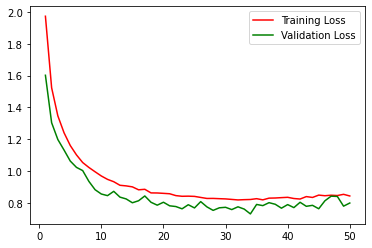

In [8]:
## YOUR CODE HERE ##
plt.plot(list(range(1,epochs+1)),T_losses,"r-",label = 'Training Loss')
plt.plot(list(range(1,epochs+1)),V_losses,"g-",label = 'Validation Loss')
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [9]:
## YOUR CODE HERE ##
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.load_state_dict(torch.load('model.pt'))

model.eval()
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.cuda(), target.cuda()

    output = model(data)
    loss = loss_fn(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    

    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    for i in range(20):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.703371

Test Accuracy of plane: 79% (791/1000)
Test Accuracy of   car: 85% (853/1000)
Test Accuracy of  bird: 59% (594/1000)
Test Accuracy of   cat: 66% (666/1000)
Test Accuracy of  deer: 77% (778/1000)
Test Accuracy of   dog: 61% (611/1000)
Test Accuracy of  frog: 81% (816/1000)
Test Accuracy of horse: 82% (821/1000)
Test Accuracy of  ship: 84% (849/1000)
Test Accuracy of truck: 88% (887/1000)

Test Accuracy (Overall): 76% (7666/10000)


## Saving your model
Using `torch.save`, save your model for future loading.

In [10]:
## YOUR CODE HERE ##
print("Already Saved During Training")

Already Saved During Training


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

**Result:** I recommend building our own model as in the few attempts, we outperformed the listed model with 76% accuracy to 70%. Also, our model is not bulky or computation hungry, and it's fast while training and predicting and I believe if we put in some more efforts, we can increase it to somewhere around 80%, which is a great model given that we were going for a 70% model. 